In [ ]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchinfo import summary


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
trsf = torchvision.transforms.Compose([ torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

In [4]:
data_train = torchvision.datasets.CIFAR10(root='cifar10', train=True, transform=trsf, download=True)
data_test = torchvision.datasets.CIFAR10(root='cifar10', train=False, transform=trsf, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=32, shuffle=False)

In [6]:
def plot_CIFAR10(data_loader: torch.utils.data.DataLoader, predict: np.ndarray = None):
    _, axes = plt.subplots(1, 10, figsize=(30, 2))

    indices = np.random.choice(data_loader.dataset.data.shape[0], 10)

    for i in range(10):
        input = data_loader.dataset.data[indices[i]]
        label = data_loader.dataset.classes[data_loader.dataset.targets[indices[i]]]
        axes[i].imshow(input)
        axes[i].axis('off')
        axes[i].set_title(f'label: {label}' + (f' \npredict: {data_loader.dataset.classes[predict[indices[i]]]}' if predict is not None else ''))

    plt.show()

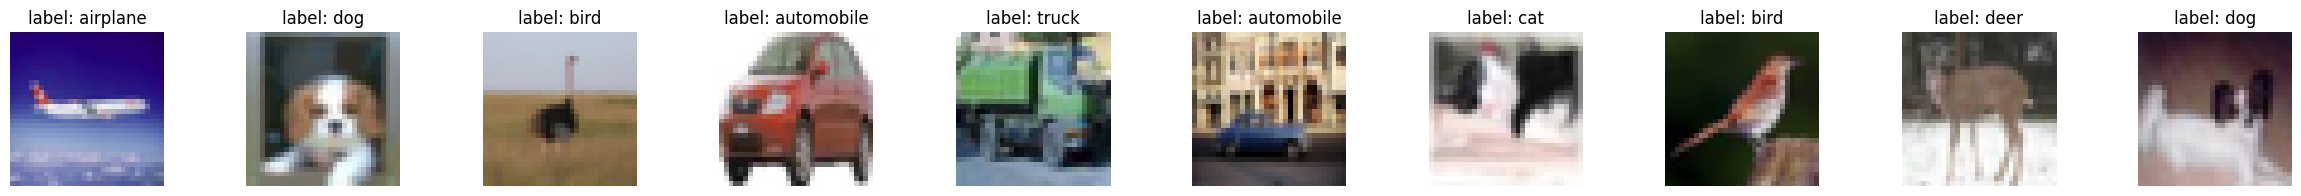

In [7]:
plot_CIFAR10(loader_train)

In [8]:
class NNet(torch.nn.Module):
    def __init__(self):
        super(NNet, self).__init__()

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),

            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        self.fully_connected = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 10)
        )

    def forward(self, data):
        output = self.features(data)
        output = self.fully_connected(output)

        return output

In [10]:
model = NNet().to(device)
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NNet                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 16, 16]          256
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-8                    [1, 128, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 256, 8, 8]            295,168
│    └─BatchNorm2d: 2-10                 [1, 256, 8, 8]            512
│    └─ReLU: 2-11                        [1, 256, 8, 8]            --


In [11]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
loss_total = []
accuracy_total = []

In [13]:
model.train()

epoch_count = 30

for epoch in range(1, epoch_count + 1):
    start_time = time()
    loss_test = 0
    accuracy_test = 0
    for inputs, labels in loader_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_test += loss.item() * len(inputs)
        accuracy_test += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    loss_total.append(loss_test / len(loader_train.dataset))
    accuracy_total.append(accuracy_test / len(loader_train.dataset))
    end_time = time()
    print(f'Epoch: {epoch}/{epoch_count} | loss: {loss_test / len(loader_train.dataset)} | accuracy: {accuracy_test / len(loader_train.dataset)} | time: {end_time - start_time}')


Epoch: 1/30 | loss: 1.5698627660369873 | accuracy: 0.40464 | time: 46.160696506500244
Epoch: 2/30 | loss: 0.9914142728996277 | accuracy: 0.64548 | time: 45.95337128639221
Epoch: 3/30 | loss: 0.754035565700531 | accuracy: 0.73758 | time: 45.925546169281006
Epoch: 4/30 | loss: 0.604577465019226 | accuracy: 0.79218 | time: 45.970967054367065
Epoch: 5/30 | loss: 0.49668082158088683 | accuracy: 0.83004 | time: 46.03102922439575
Epoch: 6/30 | loss: 0.3959911557340622 | accuracy: 0.86334 | time: 46.280396938323975
Epoch: 7/30 | loss: 0.31367275140285494 | accuracy: 0.89314 | time: 46.20326638221741
Epoch: 8/30 | loss: 0.2488888409936428 | accuracy: 0.91414 | time: 54.79444336891174
Epoch: 9/30 | loss: 0.1932601002907753 | accuracy: 0.93236 | time: 54.916513442993164
Epoch: 10/30 | loss: 0.15276415222227574 | accuracy: 0.94714 | time: 49.98508262634277
Epoch: 11/30 | loss: 0.12288712968364358 | accuracy: 0.95782 | time: 47.332515001297
Epoch: 12/30 | loss: 0.10472554525824264 | accuracy: 0.963

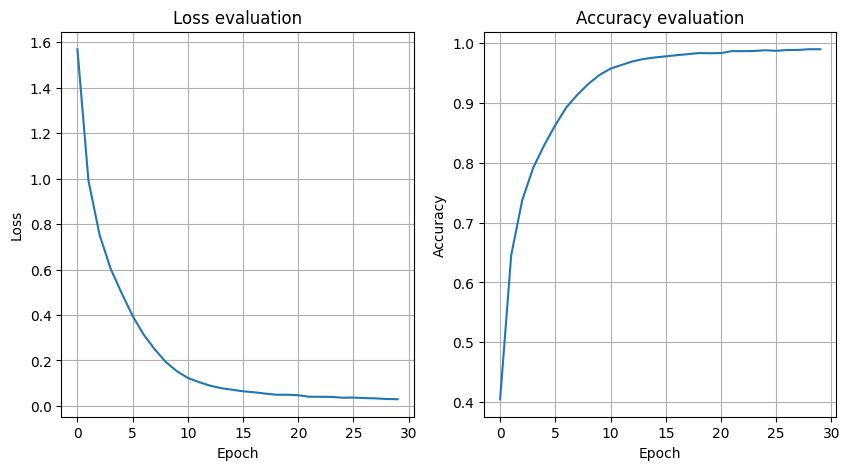

In [14]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(range(epoch_count), loss_total)
axes[0].axis('on')
axes[0].set_title('Loss evaluation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(range(epoch_count), accuracy_total)
axes[1].axis('on')
axes[1].set_title('Accuracy evaluation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.show()

In [15]:
model.eval()

loss_test = 0
accuracy_test = 0
predict = []

with torch.no_grad():
    for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predict.extend(outputs.argmax(1).tolist())
        loss = criterion(outputs, labels)
        loss_test += loss.item() * len(inputs)
        accuracy_test += (outputs.argmax(1) == labels).type(torch.float).sum().item()
print(f'Test loss: {loss_test / len(loader_test.dataset)} | test accuracy {accuracy_test / len(loader_test.dataset)}')

Test loss: 0.9138426738262176 | test accuracy 0.829


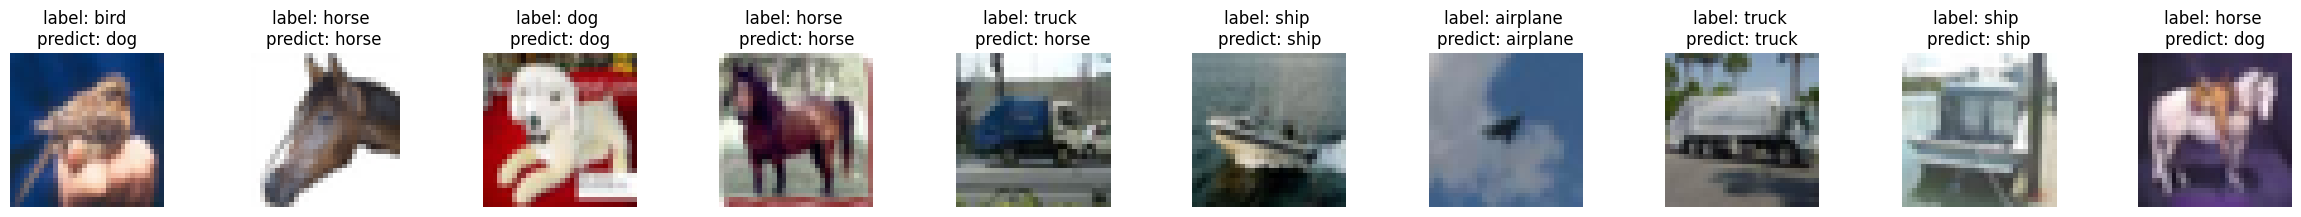

In [16]:
plot_CIFAR10(loader_test, predict)